In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.elfnn import ELFNN

In [2]:
# instantiate ELFNN object
elf = ELFNN()

### Load and analyze training data

In [3]:
elf.load_data(sort=True, structure=True, additional=True, drop_duplicates=True)

Parse additional: 100%|██████████| 100/100 [00:00<00:00, 9126.58it/s]           


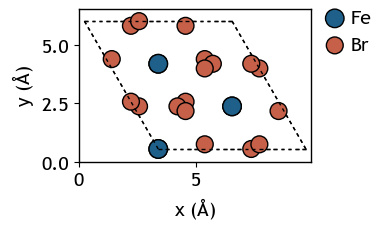

In [4]:
elf.plot_structure(elf.bm.iloc[0].structure);

In [5]:
elf.pca_fit(ev=0.9995)             # perform PCA on the ELF profiles

In [6]:
elf.get_distances(column='elf')    # compute distances from unlabeled examples to most similar labeled example

Compute EMD: 100%|██████████| 186387/186387 [00:14<00:00, 12594.68it/s]         


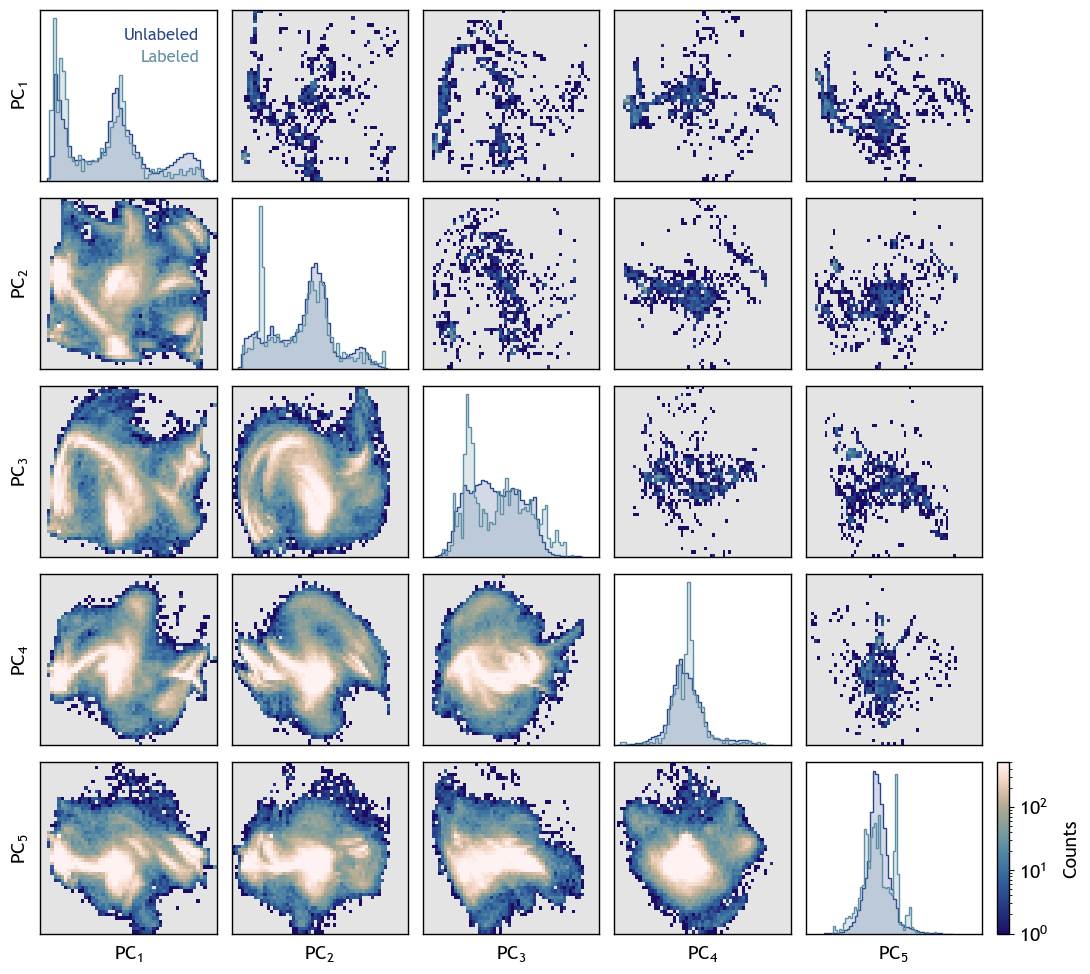

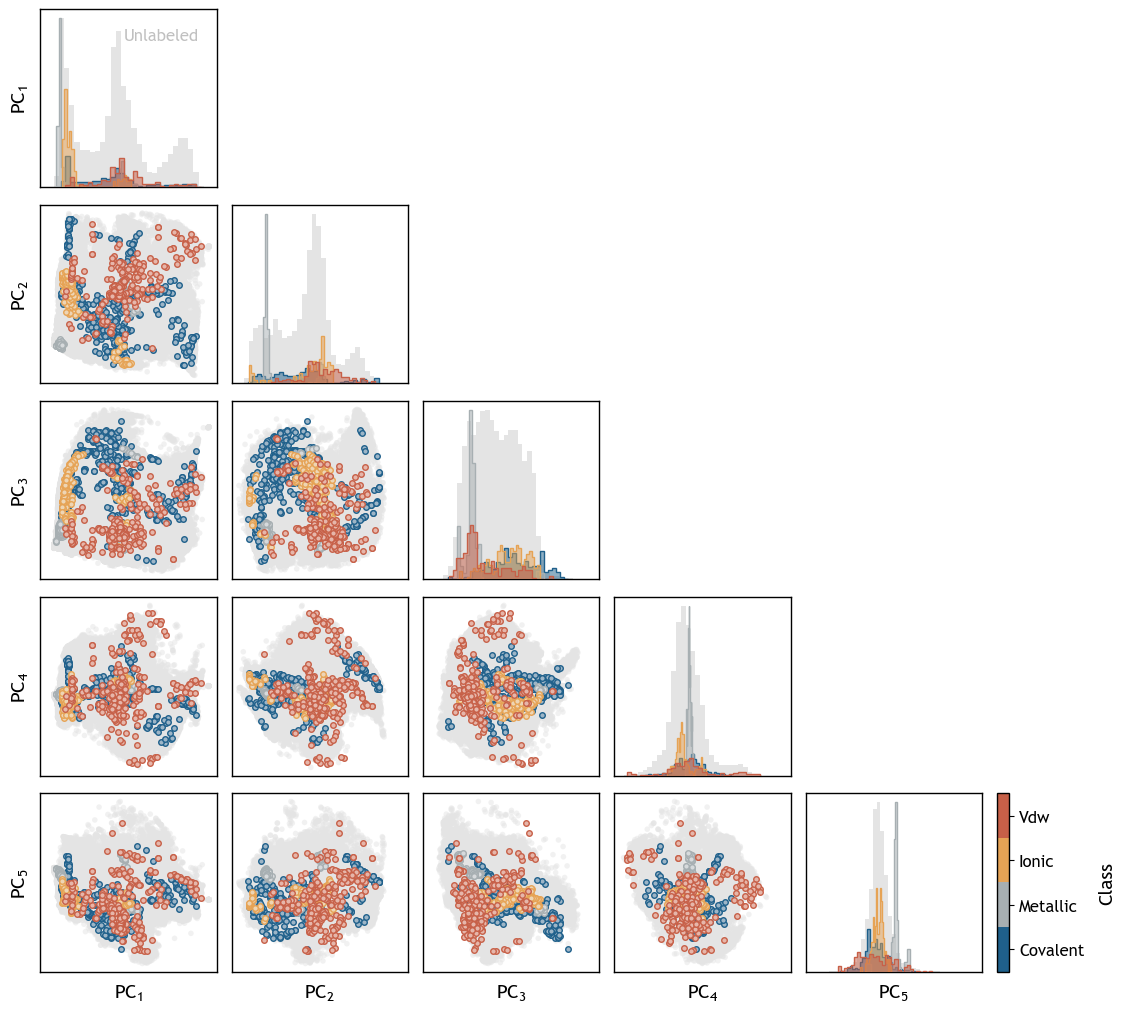

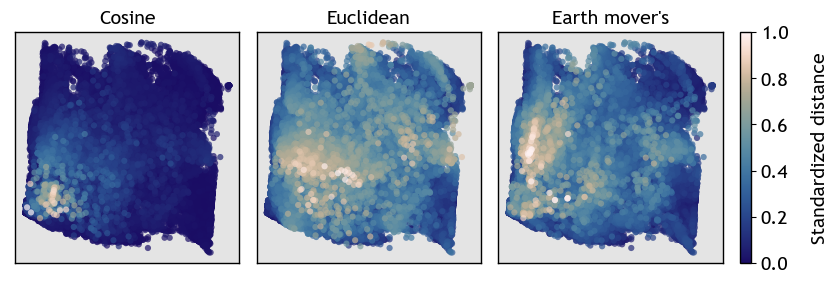

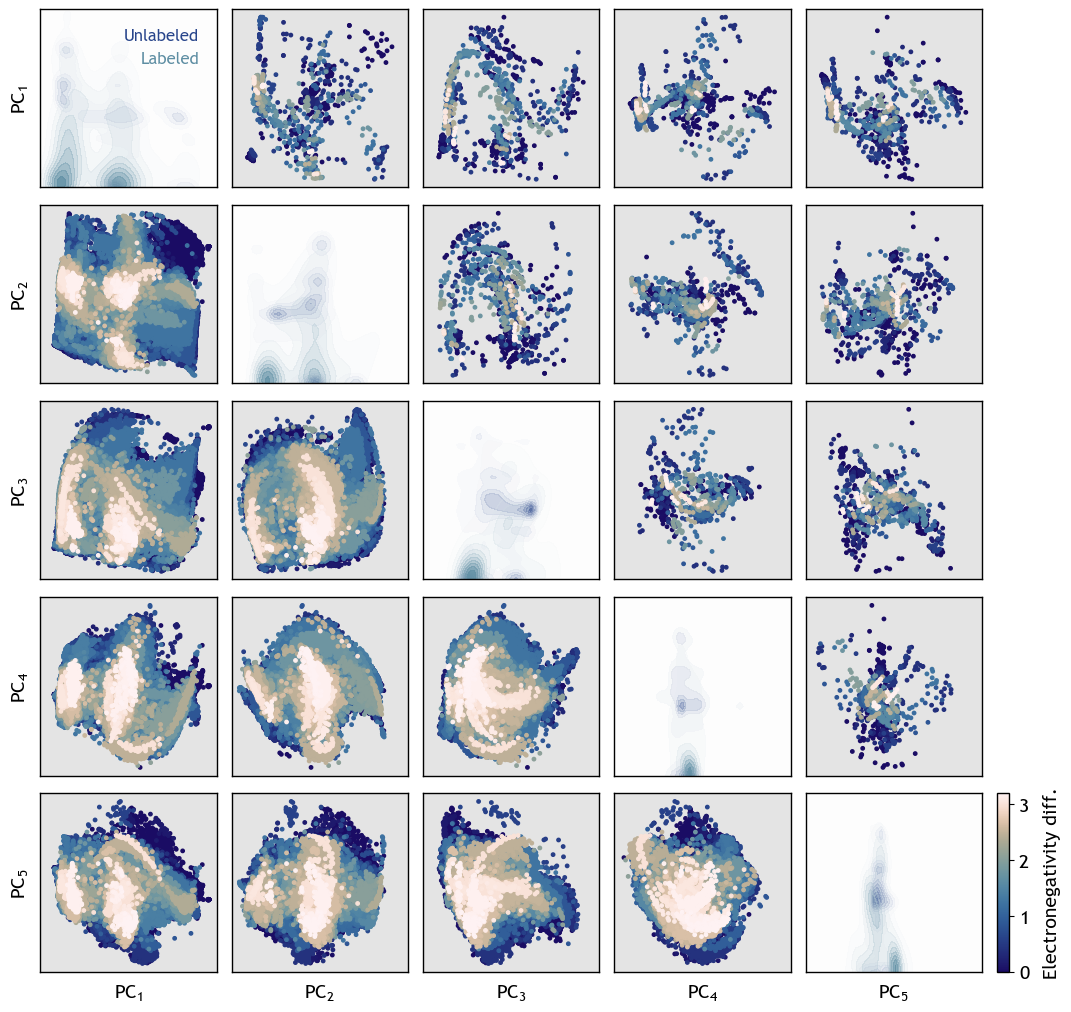

In [7]:
elf.plot_pca_distribution(orig=True)         # visualize distribution of examples in principal component space
elf.plot_pca_labels(orig=True)               # visualize distribution of labels in principal component space
elf.plot_pca_distances(orig=True)            # plot distance to most similar labeled example
elf.plot_pca_features('e_diff', orig=True);  # visualize distribution of features in principal component space

### Process data and train networks

In [8]:
# transform data
elf.pca_fit(ev=0.9995)                         # reduce dimensionality of ELF profiles
elf.prepare_inputs(inputs=['z', 'e_diff'])     # define input columns
elf.scaler_fit()                               # standardize input columns

In [26]:
# train/test split
test_size = 0.2
elf.stratified_split(test_size)                # train/test split

n_splits = 100
elf.kfold_split(n_splits, test_size)           # ensemble split

Class weights: [0.12217098 0.28674248 0.33851543 0.2525711 ]


In [27]:
# define and train models
model_path = 'models/stc_122122_srt_pca_en'
threshold = 0.4
#threshold = np.append(np.arange(0.3,0.9,0.1), 0.999)
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)                 # define classifier hyperparameters
elf.self_train_clf(threshold=threshold, max_iter=50, model_path=model_path)   # self-train classifier

100%|██████████| 100/100 [3:24:54<00:00, 122.95s/it]                            


In [ ]:
# define and train models
model_path = 'models/clf_122122_srt_pca_en'
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)    # define classifier hyperparameters
elf.train_clf(model_path=model_path)                             # train classifier

In [ ]:
# evaluate trained models

### Predict on target data using trained networks

In [28]:
# load trained network
model_path = 'models/stc_122122_srt_pca_en'
elf.load_model(model_path)

In [33]:
# load target examples
data = elf.load_data(dirname='data/unlabeled/', structure=True, additional=True)

Parse additional: 100%|██████████| 2355/2355 [00:00<00:00, 3633.04it/s]         


In [34]:
# transform target data
data = elf.pca_transform(data)
data = elf.prepare_inputs(inputs=['z', 'e_diff'], data=data)
data = elf.scaler_transform(data)

In [35]:
# predict on target data
data = elf.predict(data, threshold=0)

Threshold: 0.4


In [15]:
# regroup data by material
data = elf.regroup(data, by=['id', 'formula', 'structure'], columns=['y_class', 'y_class_mean', 'y_class_std'])